In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9727306331742244318
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8855182400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1485826396553596559
physical_device_desc: "device: 0, name: GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import time

start = time.time()

## Load data

In [5]:
directory = "Testing_data/"
stock_data_list = []

for filename in os.listdir(directory):
    if len(filename) > 10:
        continue
    file_path = os.path.join(directory, filename)
    stock_data = pd.read_csv(file_path)
    stock_data = stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    stock_data['Date'] = pd.to_datetime(stock_data.Date)
    stock_data_list.append(stock_data)
    print('Loaded file: ' + filename)

for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

Loaded file: acp_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: dnp_d.csv
Loaded file: kgh_d.csv
Loaded file: pkn_d.csv


In [6]:
def get_moving_average(data, period):
    data['MA'] = data['Close'].rolling(period).mean()
    return data

In [7]:
def get_RSI (data, period):
    increase_difference, decrease_difference = data['Close'].diff(), data['Close'].diff()
    increase_difference[increase_difference < 0] = 0
    decrease_difference[decrease_difference > 0] = 0
    roll_increase = increase_difference.ewm(span = period).mean()
    roll_decrease = decrease_difference.abs().ewm(span = period, adjust=False).mean()
    RS = roll_increase / roll_decrease
    data['RSI'] = 100 - (100 / (1 + RS))
    return data

In [8]:
def get_ROC(data):
    data['ROC'] = data['Close'].pct_change()
    return data

In [9]:
def get_stochastic_oscillator(data, period):
    L14, H14 = data['Close'].rolling(period).min(), data['Close'].rolling(period).max()
    data['K'] = (data['Close'] - L14)/(H14 - L14)
    return data

In [10]:
def get_SO_moving_average(data, so_period, ma_period):
    L, H = data['Close'].rolling(so_period).min(), data['Close'].rolling(so_period).max()
    K = (data['Close'] - L)/(H - L)
    data['D'] = K.rolling(ma_period).mean()
    return data

In [11]:
def get_MACD(data, period_long, period_short):
    EMA_long = data['Close'].ewm(period_long, adjust=False).mean()
    EMA_short = data['Close'].ewm(period_short, adjust=False).mean()
    data['MACD'] = EMA_short - EMA_long
    return data

In [12]:
def get_MACD_histogram(data, period_long, period_short, period_signal):
    EMA_long = data['Close'].ewm(period_long, adjust=False).mean()
    EMA_short = data['Close'].ewm(period_short, adjust=False).mean()
    MACD = EMA_short - EMA_long
    MACD_signal = MACD.ewm(9, adjust=False).mean()
    data['MACD_Histogram'] = MACD - MACD_signal
    return data

In [13]:
def get_PPO(data, period_long, period_short):
    EMA_long = data['Close'].ewm(period_long, adjust=False).mean()
    EMA_short = data['Close'].ewm(period_short, adjust=False).mean()
    data['PPO'] = (EMA_short - EMA_long)/EMA_long
    return data

In [14]:
def get_TEMA(data, period):
    SEMA = data['Close'].ewm(period, adjust=False).mean()
    DEMA = SEMA.ewm(period, adjust=False).mean()
    data['TEMA'] = DEMA.ewm(period, adjust=False).mean()
    return(data)

In [15]:
def get_CGI(data, period):
    typical_price = (data['Highest'] + data['Lowest'] + data['Close']) / 3
    MA = typical_price.rolling(period).mean()
    mean_deviation = (MA - typical_price).abs().rolling(period).mean()
    data['CCI'] = (typical_price - MA) / (0.15 * mean_deviation)
    return(data)

In [16]:
def get_Williams_Percent_Range(data, period):
    data['Percent_Range'] = (data['Highest'].rolling(period).max() - data['Close']) / (data['Highest'].rolling(period).max() - data['Lowest'].rolling(period).min())
    return(data)

In [17]:
def scale_data(data):
    list_of_features = []
    for column in data.columns:
        list_of_features.append(data[column])

    dataset = np.transpose(list_of_features)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    return scaled_data, scaler

In [18]:
def scale_data_X_Y(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler

In [19]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

# Testing for the best technical indicators parameters

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Checking how algorithm works without techincal indicators (learning based on prices and volume)

In [21]:
X_all = []
Y_all = []
stocks_base = []
results_base = []
# prepare data
for stock in stock_data_list:
    stock = stock.dropna()
    scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
    stocks_base.append(scaled_stock)
# split for training and validation
for stock in stocks_base:
    X, Y = prepare_input_and_output(np.array(stock))
    X_all = X_all + X
    Y_all = Y_all + Y
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)
loss_results = []
val_loss_results = []
for i in range(3):
    model = Sequential()
    model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(Y_train.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
    loss_results.append(history.history['loss'][-1])
    val_loss_results.append(history.history['val_loss'][-1])
results_base.append({'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_base = pd.DataFrame(results_base)

(27145, 60, 5)
(3017, 60, 5)
(27145, 5)
(3017, 5)
Epoch 1/7
849/849 [==============================] - 7s 5ms/step - loss: 0.0139 - val_loss: 6.7809e-04
Epoch 2/7
849/849 [==============================] - 3s 4ms/step - loss: 5.9158e-04 - val_loss: 6.1357e-04
Epoch 3/7
849/849 [==============================] - 3s 4ms/step - loss: 5.2756e-04 - val_loss: 5.9253e-04
Epoch 4/7
849/849 [==============================] - 3s 4ms/step - loss: 5.3208e-04 - val_loss: 5.3703e-04
Epoch 5/7
849/849 [==============================] - 3s 4ms/step - loss: 4.8223e-04 - val_loss: 5.2861e-04
Epoch 6/7
849/849 [==============================] - 3s 4ms/step - loss: 4.5095e-04 - val_loss: 5.7585e-04
Epoch 7/7
849/849 [==============================] - 3s 4ms/step - loss: 4.8126e-04 - val_loss: 5.0602e-04
Epoch 1/7
849/849 [==============================] - 5s 4ms/step - loss: 0.0356 - val_loss: 6.6215e-04
Epoch 2/7
849/849 [==============================] - 3s 4ms/step - loss: 5.6133e-04 - val_loss: 6.0890

In [22]:
results_base

,loss,val_loss
0,0.000449,0.000508


### Moving average

In [23]:
periods = [3, 5, 10, 15, 20, 30, 45, 60, 80, 100, 125, 150, 200]
X_all_MA = []
Y_all_MA = []
results_MA = []


for period in periods:
    X_all_MA = []
    Y_all_MA = []
    stocks_MA = []
    # prepare data
    for stock in stock_data_list:
        stock_MA = get_moving_average(stock, period)
        stock_MA = stock_MA.dropna()
        scaled_stock, stock_scaler = scale_data(stock_MA.drop(columns='Date'))
        stocks_MA.append(scaled_stock)
    # split for training and validation
    for stock_MA in stocks_MA:
        X, Y = prepare_input_and_output(np.array(stock_MA))
        X_all_MA = X_all_MA + X
        Y_all_MA = Y_all_MA + Y
    X_all_MA, Y_all_MA = np.array(X_all_MA), np.array(Y_all_MA)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all_MA, Y_all_MA, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_MA.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MA = pd.DataFrame(results_MA)


(27133, 60, 6)
(3015, 60, 6)
(27133, 5)
(3015, 5)
Period: 3
Epoch 1/7
848/848 [==============================] - 5s 4ms/step - loss: 0.0143 - val_loss: 6.1277e-04
Epoch 2/7
848/848 [==============================] - 3s 4ms/step - loss: 5.5806e-04 - val_loss: 6.1309e-04
Epoch 3/7
848/848 [==============================] - 3s 4ms/step - loss: 5.6216e-04 - val_loss: 5.4243e-04
Epoch 4/7
848/848 [==============================] - 3s 4ms/step - loss: 5.0014e-04 - val_loss: 5.3499e-04
Epoch 5/7
848/848 [==============================] - 3s 4ms/step - loss: 5.4365e-04 - val_loss: 4.9141e-04
Epoch 6/7
848/848 [==============================] - 3s 4ms/step - loss: 4.7639e-04 - val_loss: 4.8857e-04
Epoch 7/7
848/848 [==============================] - 3s 4ms/step - loss: 4.5928e-04 - val_loss: 4.8265e-04
Epoch 1/7
848/848 [==============================] - 5s 4ms/step - loss: 0.0294 - val_loss: 6.5676e-04
Epoch 2/7
848/848 [==============================] - 3s 4ms/step - loss: 5.8079e-04 - val_lo

837/837 [==============================] - 3s 4ms/step - loss: 5.4380e-04 - val_loss: 5.7526e-04
Epoch 4/7
837/837 [==============================] - 3s 4ms/step - loss: 4.9121e-04 - val_loss: 5.3259e-04
Epoch 5/7
837/837 [==============================] - 3s 4ms/step - loss: 4.7630e-04 - val_loss: 5.8031e-04
Epoch 6/7
837/837 [==============================] - 3s 4ms/step - loss: 4.7978e-04 - val_loss: 5.1669e-04
Epoch 7/7
837/837 [==============================] - 3s 4ms/step - loss: 4.5174e-04 - val_loss: 5.1340e-04
Epoch 1/7
837/837 [==============================] - 5s 4ms/step - loss: 0.0113 - val_loss: 6.5800e-04
Epoch 2/7
837/837 [==============================] - 3s 4ms/step - loss: 5.5916e-04 - val_loss: 5.9342e-04
Epoch 3/7
837/837 [==============================] - 3s 4ms/step - loss: 5.1904e-04 - val_loss: 5.4070e-04
Epoch 4/7
837/837 [==============================] - 3s 4ms/step - loss: 4.9952e-04 - val_loss: 5.2635e-04
Epoch 5/7
837/837 [==============================] 

In [24]:
results_MA

,period,loss,val_loss
0,3,0.000465,0.000484
1,5,0.000472,0.000518
2,10,0.000478,0.000382
3,15,0.000473,0.000456
4,20,0.000474,0.000469
5,30,0.000481,0.000481
6,45,0.000475,0.000452
7,60,0.000467,0.000510
8,80,0.000484,0.000386
9,100,0.000470,0.000521


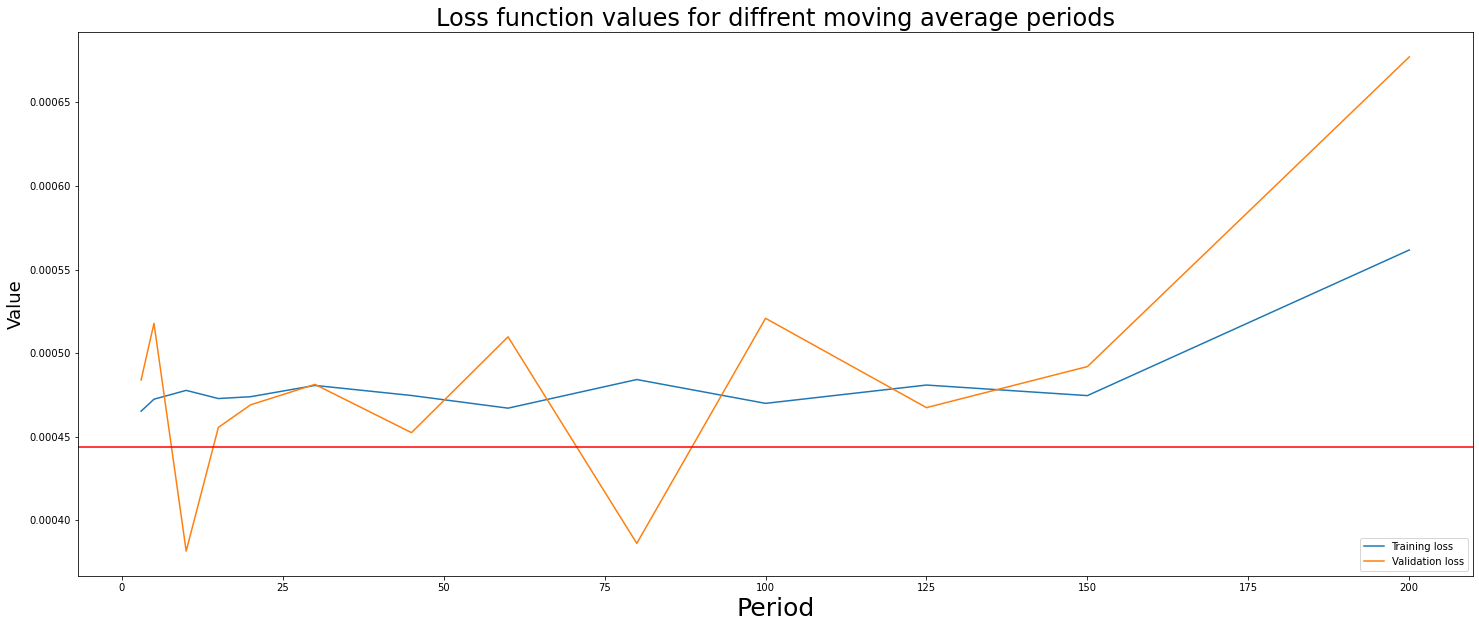

In [25]:
plt.figure(figsize=(25,10))
plt.title('Loss function values for diffrent moving average periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_MA['period'], results_MA[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

### RSI

In [26]:
periods = [3, 5, 7, 10, 14]
X_all = []
Y_all = []
results_RSI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_RSI(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_RSI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_RSI = pd.DataFrame(results_RSI)


(25892, 60, 7)
(2877, 60, 7)
(25892, 5)
(2877, 5)
Period: 3
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0404 - val_loss: 7.3358e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9042e-04 - val_loss: 7.0135e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5585e-04 - val_loss: 6.7255e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5307e-04 - val_loss: 6.6979e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5361e-04 - val_loss: 7.0420e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9660e-04 - val_loss: 6.5532e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3708e-04 - val_loss: 7.0388e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0085 - val_loss: 7.2273e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9020e-04 - val_lo

Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4509e-04 - val_loss: 5.7706e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7823e-04 - val_loss: 5.5503e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0289 - val_loss: 7.5136e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.9979e-04 - val_loss: 6.3404e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.1358e-04 - val_loss: 5.9208e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9949e-04 - val_loss: 6.3653e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6385e-04 - val_loss: 6.3931e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6317e-04 - val_loss: 6.3917e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3731e-04 - val_loss: 5.6546e-04
(25892, 60, 7)
(2877, 60, 7)
(25892, 5)
(

In [27]:
results_RSI

,period,loss,val_loss
0,3,0.000547,0.000677
1,5,0.000573,0.000483
2,7,0.000561,0.000598
3,10,0.000560,0.000566
4,14,0.000565,0.000549


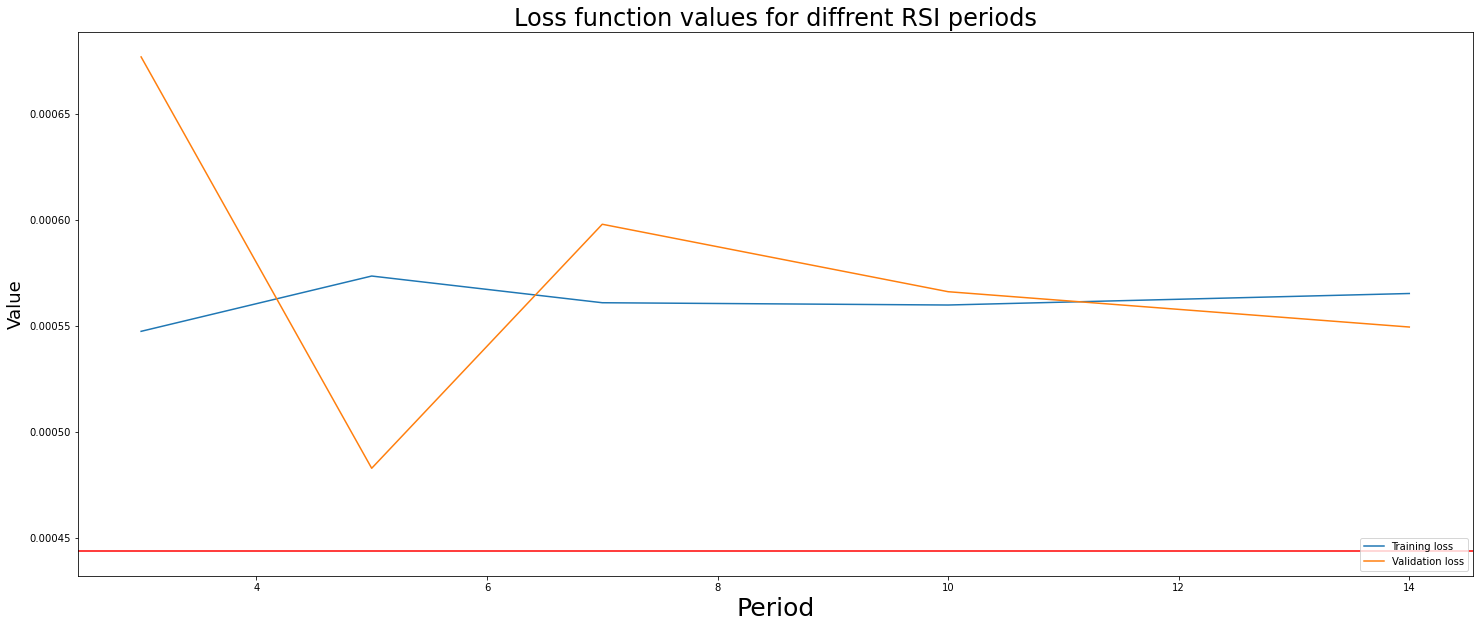

In [28]:
plt.figure(figsize=(25,10))
plt.title('Loss function values for diffrent RSI periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_RSI['period'], results_RSI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## ROC

In [29]:
X_all = []
Y_all = []
results_ROC = []


X_all = []
Y_all = []
stocks = []
# prepare data
for stock in stock_data_list:
    stock = get_ROC(stock)
    stock = stock.dropna()
    scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
    stocks.append(scaled_stock)
# split for training and validation
for stock in stocks:
    X, Y = prepare_input_and_output(np.array(stock))
    X_all = X_all + X
    Y_all = Y_all + Y
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

loss_results = []
val_loss_results = []
for i in range(3):
    model = Sequential()
    model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(Y_train.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
    loss_results.append(history.history['loss'][-1])
    val_loss_results.append(history.history['val_loss'][-1])
results_ROC.append({'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_ROC = pd.DataFrame(results_ROC)

(25892, 60, 8)
(2877, 60, 8)
(25892, 5)
(2877, 5)
Epoch 1/7
810/810 [==============================] - 4s 4ms/step - loss: 0.0190 - val_loss: 7.0794e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.5158e-04 - val_loss: 6.2871e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9195e-04 - val_loss: 5.9868e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7420e-04 - val_loss: 6.1086e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9583e-04 - val_loss: 5.8094e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4547e-04 - val_loss: 6.2666e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4468e-04 - val_loss: 5.8527e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0102 - val_loss: 6.4571e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.5013e-04 - val_loss: 6.2703

In [30]:
results_ROC

,loss,val_loss
0,0.000558,0.0006


## Stochastic oscillator

In [31]:
periods = [3, 5, 7, 10, 14]
X_all = []
Y_all = []
results_SO = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_stochastic_oscillator(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_SO.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_SO = pd.DataFrame(results_SO)


(25738, 60, 9)
(2860, 60, 9)
(25738, 5)
(2860, 5)
Period: 3
Epoch 1/7
805/805 [==============================] - 5s 4ms/step - loss: 0.0692 - val_loss: 0.0161
Epoch 2/7
805/805 [==============================] - 3s 4ms/step - loss: 0.0094 - val_loss: 0.0027
Epoch 3/7
805/805 [==============================] - 3s 4ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/7
805/805 [==============================] - 3s 4ms/step - loss: 8.9949e-04 - val_loss: 7.8263e-04
Epoch 5/7
805/805 [==============================] - 3s 4ms/step - loss: 6.8887e-04 - val_loss: 7.7303e-04
Epoch 6/7
805/805 [==============================] - 3s 4ms/step - loss: 5.5735e-04 - val_loss: 6.7213e-04
Epoch 7/7
805/805 [==============================] - 3s 4ms/step - loss: 5.3230e-04 - val_loss: 6.0781e-04
Epoch 1/7
805/805 [==============================] - 4s 4ms/step - loss: 0.0112 - val_loss: 7.5380e-04
Epoch 2/7
805/805 [==============================] - 3s 4ms/step - loss: 7.4706e-04 - val_loss: 6.6659e-04
Epoch

Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8891e-04 - val_loss: 6.6788e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5181e-04 - val_loss: 5.7696e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0114 - val_loss: 6.9892e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.6845e-04 - val_loss: 6.1403e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6082e-04 - val_loss: 5.9785e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.1224e-04 - val_loss: 5.6240e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8106e-04 - val_loss: 5.7874e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 6.1390e-04 - val_loss: 5.5954e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.2397e-04 - val_loss: 5.5226e-04
(25892, 60, 9)
(2877, 60, 9)
(25892, 5)
(

In [32]:
results_SO

,period,loss,val_loss
0,3,0.000560,0.000619
1,5,0.000552,0.000599
2,7,0.000560,0.000577
3,10,0.000556,0.000561
4,14,0.000564,0.000454


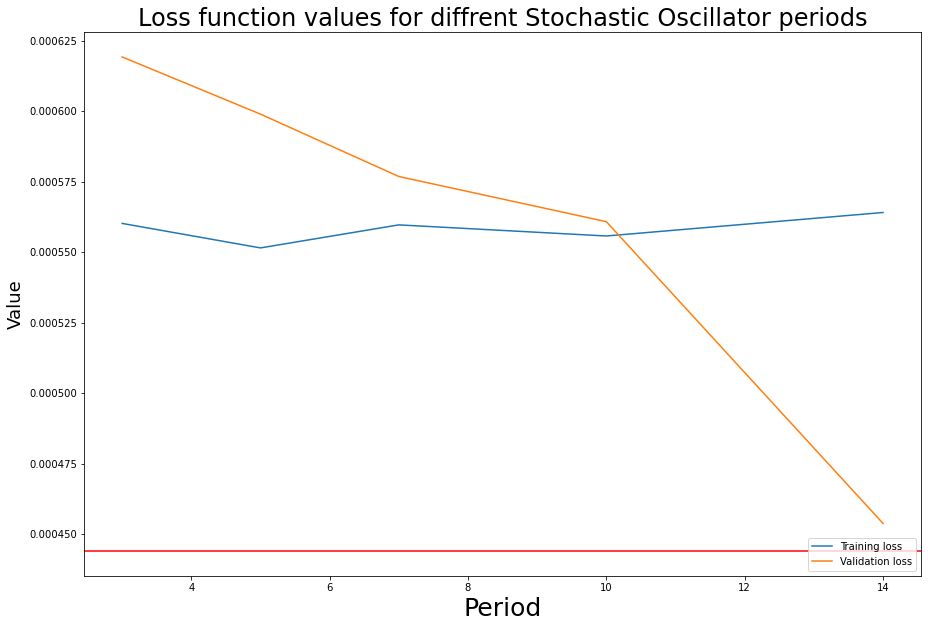

In [33]:
plt.figure(figsize=(15,10))
plt.title('Loss function values for diffrent Stochastic Oscillator periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_SO['period'], results_SO[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## Moving average of stochastic oscillator

In [34]:
so_periods = [3, 5, 7, 10, 14]
ma_periods = [2, 3, 4, 5, 6]
X_all = []
Y_all = []
results_SO_MA = []


for so_period in so_periods:
    for ma_period in ma_periods:
        X_all = []
        Y_all = []
        stocks = []
        # prepare data
        for stock in stock_data_list:
            stock = get_SO_moving_average(stock, so_period, ma_period)
            stock = stock.dropna()
            scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
            stocks.append(scaled_stock)
        # split for training and validation
        for stock in stocks:
            X, Y = prepare_input_and_output(np.array(stock))
            X_all = X_all + X
            Y_all = Y_all + Y
        X_all, Y_all = np.array(X_all), np.array(Y_all)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
        print(X_train.shape)
        print(X_valid.shape)
        print(Y_train.shape)
        print(Y_valid.shape)
        #
        print('Stochastic Oscillator period: ' + str(so_period))
        print('Moving average period: ' + str(ma_period))
        loss_results = []
        val_loss_results = []
        for i in range(3):
            model = Sequential()
            model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(Y_train.shape[1]))
            model.compile(loss='mse', optimizer='adam')
            history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
            loss_results.append(history.history['loss'][-1])
            val_loss_results.append(history.history['val_loss'][-1])
        results_SO_MA.append({'so_period': so_period, 'ma_period': ma_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_SO_MA = pd.DataFrame(results_SO_MA)


(25615, 60, 10)
(2847, 60, 10)
(25615, 5)
(2847, 5)
Stochastic Oscillator period: 3
Moving average period: 2
Epoch 1/7
801/801 [==============================] - 5s 4ms/step - loss: 0.0120 - val_loss: 5.8337e-04
Epoch 2/7
801/801 [==============================] - 3s 4ms/step - loss: 6.8577e-04 - val_loss: 5.3589e-04
Epoch 3/7
801/801 [==============================] - 3s 4ms/step - loss: 6.8161e-04 - val_loss: 5.6922e-04
Epoch 4/7
801/801 [==============================] - 3s 4ms/step - loss: 6.1717e-04 - val_loss: 5.6038e-04
Epoch 5/7
801/801 [==============================] - 3s 4ms/step - loss: 5.9016e-04 - val_loss: 7.2023e-04
Epoch 6/7
801/801 [==============================] - 3s 4ms/step - loss: 5.6169e-04 - val_loss: 5.2894e-04
Epoch 7/7
801/801 [==============================] - 3s 4ms/step - loss: 6.4750e-04 - val_loss: 5.0213e-04
Epoch 1/7
801/801 [==============================] - 5s 5ms/step - loss: 0.0108 - val_loss: 8.1972e-04
Epoch 2/7
801/801 [========================

Epoch 4/7
790/790 [==============================] - 3s 4ms/step - loss: 5.9848e-04 - val_loss: 7.0041e-04
Epoch 5/7
790/790 [==============================] - 3s 4ms/step - loss: 5.7297e-04 - val_loss: 6.8746e-04
Epoch 6/7
790/790 [==============================] - 3s 4ms/step - loss: 5.8588e-04 - val_loss: 8.2519e-04
Epoch 7/7
790/790 [==============================] - 3s 4ms/step - loss: 5.7985e-04 - val_loss: 6.9225e-04
Epoch 1/7
790/790 [==============================] - 4s 4ms/step - loss: 0.0083 - val_loss: 7.4190e-04
Epoch 2/7
790/790 [==============================] - 3s 4ms/step - loss: 6.3724e-04 - val_loss: 7.1621e-04
Epoch 3/7
790/790 [==============================] - 3s 4ms/step - loss: 5.9558e-04 - val_loss: 6.8569e-04
Epoch 4/7
790/790 [==============================] - 3s 4ms/step - loss: 5.8859e-04 - val_loss: 7.3916e-04
Epoch 5/7
790/790 [==============================] - 3s 4ms/step - loss: 5.5599e-04 - val_loss: 7.2119e-04
Epoch 6/7
790/790 [======================

(25866, 60, 10)
(2874, 60, 10)
(25866, 5)
(2874, 5)
Stochastic Oscillator period: 5
Moving average period: 4
Epoch 1/7
809/809 [==============================] - 5s 4ms/step - loss: 0.0141 - val_loss: 7.5915e-04
Epoch 2/7
809/809 [==============================] - 3s 4ms/step - loss: 6.2659e-04 - val_loss: 7.1957e-04
Epoch 3/7
809/809 [==============================] - 3s 4ms/step - loss: 5.7811e-04 - val_loss: 6.7815e-04
Epoch 4/7
809/809 [==============================] - 3s 4ms/step - loss: 5.4113e-04 - val_loss: 7.1296e-04
Epoch 5/7
809/809 [==============================] - 3s 4ms/step - loss: 5.6998e-04 - val_loss: 6.5451e-04
Epoch 6/7
809/809 [==============================] - 3s 4ms/step - loss: 5.6553e-04 - val_loss: 6.3152e-04
Epoch 7/7
809/809 [==============================] - 3s 4ms/step - loss: 5.6642e-04 - val_loss: 6.3799e-04
Epoch 1/7
809/809 [==============================] - 4s 4ms/step - loss: 0.0339 - val_loss: 0.0011
Epoch 2/7
809/809 [============================

Epoch 4/7
809/809 [==============================] - 3s 3ms/step - loss: 6.1236e-04 - val_loss: 5.6483e-04
Epoch 5/7
809/809 [==============================] - 3s 3ms/step - loss: 5.6810e-04 - val_loss: 5.9251e-04
Epoch 6/7
809/809 [==============================] - 3s 3ms/step - loss: 5.7890e-04 - val_loss: 5.8835e-04
Epoch 7/7
809/809 [==============================] - 3s 3ms/step - loss: 5.5814e-04 - val_loss: 5.4779e-04
Epoch 1/7
809/809 [==============================] - 4s 4ms/step - loss: 0.0122 - val_loss: 6.5559e-04
Epoch 2/7
809/809 [==============================] - 3s 3ms/step - loss: 6.4885e-04 - val_loss: 5.9164e-04
Epoch 3/7
809/809 [==============================] - 3s 3ms/step - loss: 6.1935e-04 - val_loss: 5.7160e-04
Epoch 4/7
809/809 [==============================] - 3s 3ms/step - loss: 5.9906e-04 - val_loss: 5.7178e-04
Epoch 5/7
809/809 [==============================] - 3s 3ms/step - loss: 5.8161e-04 - val_loss: 5.5050e-04
Epoch 6/7
809/809 [======================

(25884, 60, 10)
(2877, 60, 10)
(25884, 5)
(2877, 5)
Stochastic Oscillator period: 7
Moving average period: 6
Epoch 1/7
809/809 [==============================] - 4s 4ms/step - loss: 0.0097 - val_loss: 6.3431e-04
Epoch 2/7
809/809 [==============================] - 3s 4ms/step - loss: 6.4546e-04 - val_loss: 5.3008e-04
Epoch 3/7
809/809 [==============================] - 3s 4ms/step - loss: 6.2515e-04 - val_loss: 5.3751e-04
Epoch 4/7
809/809 [==============================] - 3s 4ms/step - loss: 6.3250e-04 - val_loss: 4.9525e-04
Epoch 5/7
809/809 [==============================] - 3s 4ms/step - loss: 5.7700e-04 - val_loss: 4.9238e-04
Epoch 6/7
809/809 [==============================] - 3s 4ms/step - loss: 5.6870e-04 - val_loss: 5.1743e-04
Epoch 7/7
809/809 [==============================] - 3s 4ms/step - loss: 5.8313e-04 - val_loss: 4.7298e-04
Epoch 1/7
809/809 [==============================] - 5s 4ms/step - loss: 0.0091 - val_loss: 9.2294e-04
Epoch 2/7
809/809 [========================

Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0141e-04 - val_loss: 4.7224e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6843e-04 - val_loss: 5.9126e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7562e-04 - val_loss: 4.6680e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8363e-04 - val_loss: 4.6146e-04
Epoch 1/7
810/810 [==============================] - 5s 5ms/step - loss: 0.0379 - val_loss: 5.9062e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.8938e-04 - val_loss: 4.9786e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0639e-04 - val_loss: 5.0970e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0537e-04 - val_loss: 4.9705e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8488e-04 - val_loss: 5.0893e-04
Epoch 6/7
810/810 [======================

(25892, 60, 10)
(2877, 60, 10)
(25892, 5)
(2877, 5)
Stochastic Oscillator period: 14
Moving average period: 3
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0096 - val_loss: 6.7056e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.1657e-04 - val_loss: 5.9871e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8001e-04 - val_loss: 5.7076e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8820e-04 - val_loss: 5.4642e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9880e-04 - val_loss: 5.6312e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8675e-04 - val_loss: 5.5854e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6996e-04 - val_loss: 5.7947e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0090 - val_loss: 6.6694e-04
Epoch 2/7
810/810 [=======================

810/810 [==============================] - 3s 4ms/step - loss: 8.6495e-04 - val_loss: 7.7599e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 6.4618e-04 - val_loss: 6.6876e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 6.2606e-04 - val_loss: 6.5750e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6459e-04 - val_loss: 5.8918e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0145 - val_loss: 7.7898e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.4638e-04 - val_loss: 7.6357e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.4642e-04 - val_loss: 6.4948e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0418e-04 - val_loss: 6.2548e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6130e-04 - val_loss: 6.0855e-04
Epoch 6/7
810/810 [==============================] 

In [35]:
results_SO_MA

,so_period,ma_period,loss,val_loss
0,3,2,0.000571,0.000487
1,3,3,0.000567,0.000600
2,3,4,0.000576,0.000456
3,3,5,0.000557,0.000686
4,3,6,0.000566,0.000582
5,5,2,0.000570,0.000460
6,5,3,0.000567,0.000459
7,5,4,0.000553,0.000641
8,5,5,0.000558,0.000556
9,5,6,0.000563,0.000557


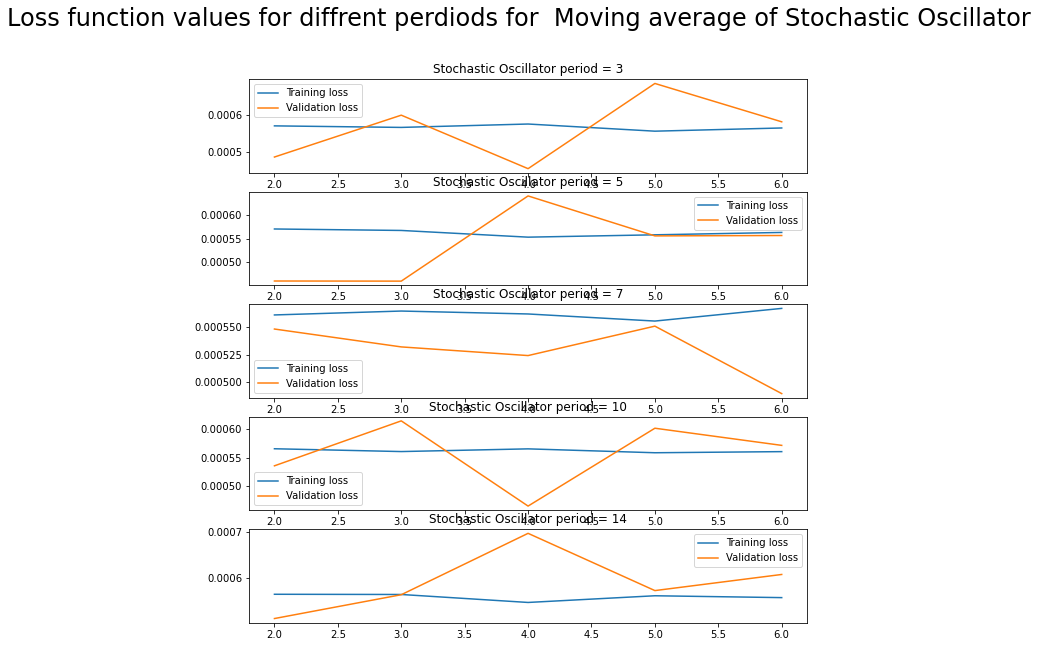

In [36]:
fig, axes = plt.subplots(len(results_SO_MA['so_period'].unique()))
fig.set_size_inches(10,10)
fig.suptitle('Loss function values for diffrent perdiods for  Moving average of Stochastic Oscillator', size=24)

axes_counter = 0
for so_period in results_SO_MA['so_period'].unique():
    axes[axes_counter].title.set_text('Stochastic Oscillator period = ' + str(so_period))
    axes[axes_counter].plot(results_SO_MA['ma_period'].where(results_SO_MA['so_period']==so_period), results_SO_MA[['loss', 'val_loss']].where(results_SO_MA['so_period']==so_period))
    axes[axes_counter].legend(['Training loss',  'Validation loss'])
    axes_counter += 1

## MACD

In [37]:
long_periods = [10, 18, 26]
short_periods = [6, 9, 12]
X_all = []
Y_all = []
results_MACD = []


for long_period in long_periods:
    for short_period in short_periods:
        if long_period <= short_period:
            continue
        X_all = []
        Y_all = []
        stocks = []
        # prepare data
        for stock in stock_data_list:
            stock = get_MACD(stock, long_period, short_period)
            stock = stock.dropna()
            scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
            stocks.append(scaled_stock)
        # split for training and validation
        for stock in stocks:
            X, Y = prepare_input_and_output(np.array(stock))
            X_all = X_all + X
            Y_all = Y_all + Y
        X_all, Y_all = np.array(X_all), np.array(Y_all)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
        print(X_train.shape)
        print(X_valid.shape)
        print(Y_train.shape)
        print(Y_valid.shape)
        #
        print('Long period: ' + str(so_period))
        print('Short period: ' + str(ma_period))
        loss_results = []
        val_loss_results = []
        for i in range(3):
            model = Sequential()
            model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(Y_train.shape[1]))
            model.compile(loss='mse', optimizer='adam')
            history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
            loss_results.append(history.history['loss'][-1])
            val_loss_results.append(history.history['val_loss'][-1])
        results_MACD.append({'long_period': long_period, 'short_period': short_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MACD = pd.DataFrame(results_MACD)

(25892, 60, 11)
(2877, 60, 11)
(25892, 5)
(2877, 5)
Long period: 14
Short period: 6
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0240 - val_loss: 5.7706e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.5563e-04 - val_loss: 5.2360e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7275e-04 - val_loss: 5.4865e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.2265e-04 - val_loss: 5.0185e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7558e-04 - val_loss: 5.2797e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0000e-04 - val_loss: 4.9123e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4579e-04 - val_loss: 4.6950e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0126 - val_loss: 6.0547e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - l

Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9748e-04 - val_loss: 5.5087e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7238e-04 - val_loss: 5.6805e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5802e-04 - val_loss: 4.9757e-04
Epoch 1/7
810/810 [==============================] - 4s 4ms/step - loss: 0.0100 - val_loss: 9.2586e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 8.5202e-04 - val_loss: 5.4481e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.1918e-04 - val_loss: 5.3246e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7043e-04 - val_loss: 5.1393e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8101e-04 - val_loss: 5.0465e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4899e-04 - val_loss: 5.4130e-04
Epoch 7/7
810/810 [======================

Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.5648e-04 - val_loss: 5.8998e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9112e-04 - val_loss: 5.7077e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6396e-04 - val_loss: 5.2764e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0551e-04 - val_loss: 5.3517e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7855e-04 - val_loss: 5.0530e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6956e-04 - val_loss: 6.7771e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0125 - val_loss: 6.2980e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.9297e-04 - val_loss: 5.9471e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9337e-04 - val_loss: 5.7008e-04
Epoch 4/7
810/810 [======================

In [38]:
results_MACD

,long_period,short_period,loss,val_loss
0,10,6,0.000566,0.000480
1,10,9,0.000557,0.000585
2,18,6,0.000570,0.000473
3,18,9,0.000562,0.000497
4,18,12,0.000544,0.000714
5,26,6,0.000557,0.000611
6,26,9,0.000558,0.000622
7,26,12,0.000565,0.000589


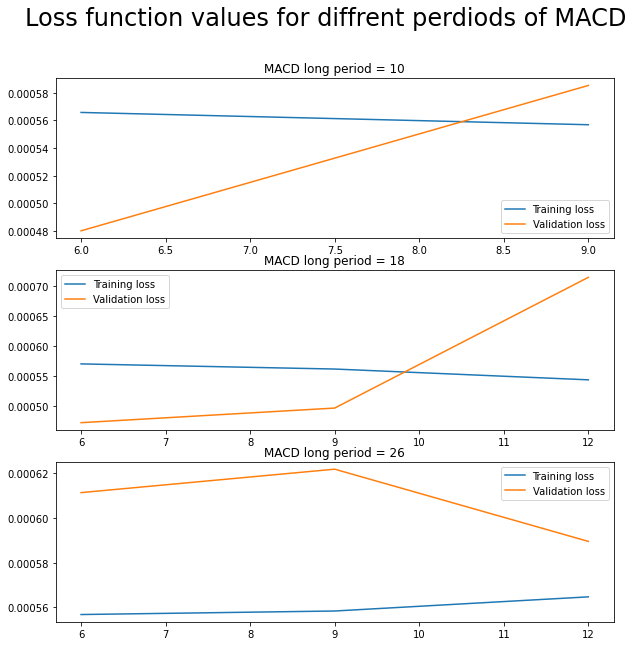

In [39]:
fig, axes = plt.subplots(len(results_MACD['long_period'].unique()))
fig.set_size_inches(10,10)
fig.suptitle('Loss function values for diffrent perdiods of MACD', size=24)

axes_counter = 0
for long_period in results_MACD['long_period'].unique():
    axes[axes_counter].title.set_text('MACD long period = ' + str(long_period))
    axes[axes_counter].plot(results_MACD['short_period'].where(results_MACD['long_period']==long_period), results_MACD[['loss', 'val_loss']].where(results_MACD['long_period']==long_period))
    axes[axes_counter].legend(['Training loss',  'Validation loss'])
    axes_counter += 1

## MACD Histogram for diffrent signal lines

In [40]:
long_period = 26
short_period = 12
signal_periods = [3, 5, 9, 12]

X_all = []
Y_all = []
results_MACD_histogram = []


for signal_period in signal_periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_MACD_histogram(stock, long_period, short_period, signal_period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Signal line period: ' + str(signal_period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_MACD_histogram.append({'long_period': long_period,'short_period': short_period,'signal_period': signal_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MACD_histogram = pd.DataFrame(results_MACD_histogram)


(25892, 60, 12)
(2877, 60, 12)
(25892, 5)
(2877, 5)
Signal line period: 3
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0130 - val_loss: 7.9387e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.8385e-04 - val_loss: 6.1612e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0633e-04 - val_loss: 6.3952e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0723e-04 - val_loss: 7.1085e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8017e-04 - val_loss: 5.4343e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5146e-04 - val_loss: 5.4823e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6039e-04 - val_loss: 5.4956e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0307 - val_loss: 8.6417e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 7.318

In [41]:
results_MACD_histogram

,long_period,short_period,signal_period,loss,val_loss
0,26,12,3,0.000558,0.000562
1,26,12,5,0.000558,0.000662
2,26,12,9,0.000565,0.000540
3,26,12,12,0.000564,0.000557


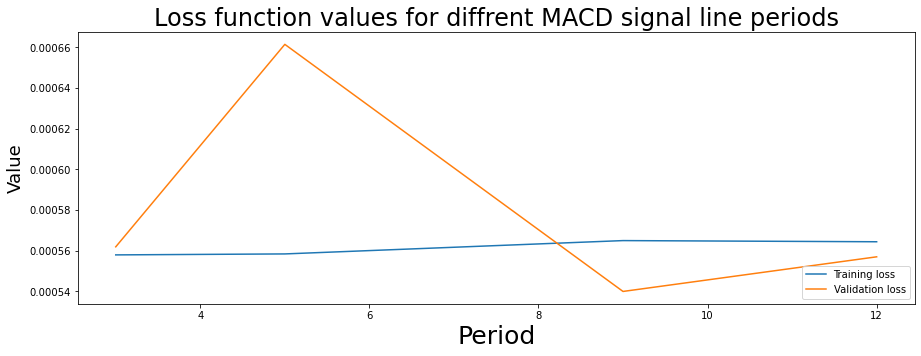

In [42]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent MACD signal line periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_MACD_histogram['signal_period'], results_MACD_histogram[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.show()

## Price Oscillator PPO

In [43]:
long_periods = [10, 18, 26]
short_periods = [6, 9, 12]
X_all = []
Y_all = []
results_PPO = []


for long_period in long_periods:
    for short_period in short_periods:
        if long_period <= short_period:
            continue
        X_all = []
        Y_all = []
        stocks = []
        # prepare data
        for stock in stock_data_list:
            stock = get_PPO(stock, long_period, short_period)
            stock = stock.dropna()
            scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
            stocks.append(scaled_stock)
        # split for training and validation
        for stock in stocks:
            X, Y = prepare_input_and_output(np.array(stock))
            X_all = X_all + X
            Y_all = Y_all + Y
        X_all, Y_all = np.array(X_all), np.array(Y_all)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
        print(X_train.shape)
        print(X_valid.shape)
        print(Y_train.shape)
        print(Y_valid.shape)
        #
        print('Long period: ' + str(so_period))
        print('Short period: ' + str(ma_period))
        loss_results = []
        val_loss_results = []
        for i in range(3):
            model = Sequential()
            model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(Y_train.shape[1]))
            model.compile(loss='mse', optimizer='adam')
            history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
            loss_results.append(history.history['loss'][-1])
            val_loss_results.append(history.history['val_loss'][-1])
        results_PPO.append({'long_period': long_period, 'short_period': short_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_PPO = pd.DataFrame(results_PPO)

(25892, 60, 13)
(2877, 60, 13)
(25892, 5)
(2877, 5)
Long period: 14
Short period: 6
Epoch 1/7
810/810 [==============================] - 4s 4ms/step - loss: 0.0170 - val_loss: 6.2195e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 7.0503e-04 - val_loss: 5.6411e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0338e-04 - val_loss: 5.0679e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.3518e-04 - val_loss: 5.1045e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8209e-04 - val_loss: 4.8539e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8049e-04 - val_loss: 5.3605e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8857e-04 - val_loss: 5.0496e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0119 - val_loss: 6.8813e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - l

Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8993e-04 - val_loss: 5.5577e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7328e-04 - val_loss: 5.7085e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8499e-04 - val_loss: 5.4710e-04
Epoch 1/7
810/810 [==============================] - 4s 4ms/step - loss: 0.0137 - val_loss: 6.8461e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.2054e-04 - val_loss: 6.1833e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.3551e-04 - val_loss: 5.9278e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.1479e-04 - val_loss: 5.7980e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7694e-04 - val_loss: 5.4886e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4631e-04 - val_loss: 5.5685e-04
Epoch 7/7
810/810 [======================

In [44]:
results_PPO

,long_period,short_period,loss,val_loss
0,10,6,0.000571,0.000498
1,10,9,0.000574,0.000459
2,18,6,0.000545,0.000694
3,18,9,0.000562,0.000553
4,18,12,0.000562,0.000551
5,26,6,0.000552,0.000551
6,26,9,0.000542,0.000731
7,26,12,0.000563,0.000553


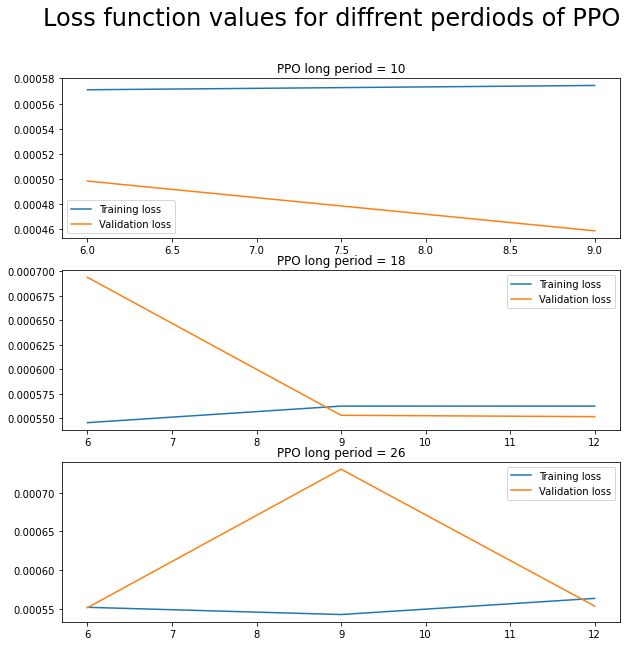

In [45]:
fig, axes = plt.subplots(len(results_PPO['long_period'].unique()))
fig.set_size_inches(10,10)
fig.suptitle('Loss function values for diffrent perdiods of PPO', size=24)

axes_counter = 0
for long_period in results_PPO['long_period'].unique():
    axes[axes_counter].title.set_text('PPO long period = ' + str(long_period))
    axes[axes_counter].plot(results_PPO['short_period'].where(results_PPO['long_period']==long_period), results_PPO[['loss', 'val_loss']].where(results_PPO['long_period']==long_period))
    axes[axes_counter].legend(['Training loss',  'Validation loss'])
    axes_counter += 1

## Triple exponential moving average TEMA

In [46]:
periods = [3, 5, 9, 12, 15, 21]

X_all = []
Y_all = []
results_TEMA = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_TEMA(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('TEMA period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_TEMA.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_TEMA = pd.DataFrame(results_TEMA)


(25892, 60, 14)
(2877, 60, 14)
(25892, 5)
(2877, 5)
TEMA period: 3
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0158 - val_loss: 7.7817e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 8.4562e-04 - val_loss: 6.3787e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.6771e-04 - val_loss: 4.9006e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0565e-04 - val_loss: 4.9608e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8309e-04 - val_loss: 4.8247e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8888e-04 - val_loss: 4.6976e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7871e-04 - val_loss: 4.6679e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0339 - val_loss: 6.0867e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.5851e-04 -

In [47]:
results_TEMA

,period,loss,val_loss
0,3,0.000567,0.000464
1,5,0.000576,0.000459
2,9,0.000564,0.000607
3,12,0.000563,0.000649
4,15,0.000559,0.000622
5,21,0.000546,0.000740


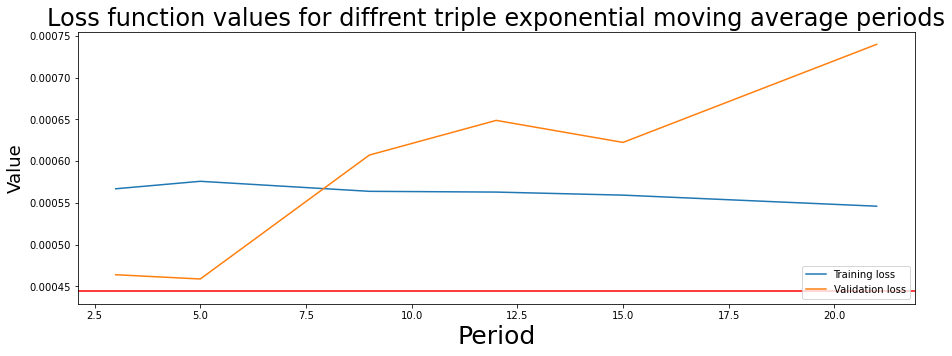

In [48]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent triple exponential moving average periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_TEMA['period'], results_TEMA[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## Commodity Channel  Index CGI

In [49]:
periods = [5, 10, 15, 20]

X_all = []
Y_all = []
results_CGI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_CGI(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('CGI period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_CGI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_CGI = pd.DataFrame(results_CGI)


(25892, 60, 15)
(2877, 60, 15)
(25892, 5)
(2877, 5)
CGI period: 5
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0096 - val_loss: 8.1050e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.7587e-04 - val_loss: 6.9226e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9701e-04 - val_loss: 7.1053e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8300e-04 - val_loss: 7.3172e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7324e-04 - val_loss: 6.3776e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.2738e-04 - val_loss: 7.9556e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.2075e-04 - val_loss: 6.4604e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0132 - val_loss: 0.0011
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 8.5511e-04 - val_

In [50]:
results_CGI

,period,loss,val_loss
0,5,0.000556,0.000717
1,10,0.000577,0.000409
2,15,0.000570,0.000599
3,20,0.000566,0.000523


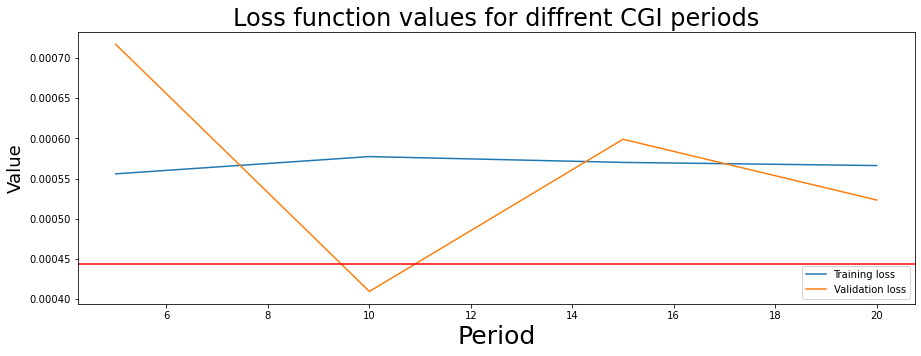

In [51]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent CGI periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_CGI['period'], results_CGI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## Williams Percent Range WPI

In [52]:
periods = [5, 7, 10, 14, 21]

X_all = []
Y_all = []
results_WPI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_Williams_Percent_Range(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('WPI period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_WPI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_WPI = pd.DataFrame(results_WPI)


(25892, 60, 16)
(2877, 60, 16)
(25892, 5)
(2877, 5)
WPI period: 5
Epoch 1/7
810/810 [==============================] - 4s 4ms/step - loss: 0.0100 - val_loss: 9.1676e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 7.6779e-04 - val_loss: 7.5988e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.7430e-04 - val_loss: 6.9804e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7898e-04 - val_loss: 7.0255e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3105e-04 - val_loss: 6.5427e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5887e-04 - val_loss: 7.4462e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4403e-04 - val_loss: 6.8174e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0086 - val_loss: 8.5636e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.7297e-04 - 

In [53]:
results_WPI

,period,loss,val_loss
0,5,0.000548,0.000671
1,7,0.000559,0.000607
2,10,0.000558,0.000587
3,14,0.000564,0.000564
4,21,0.000560,0.000613


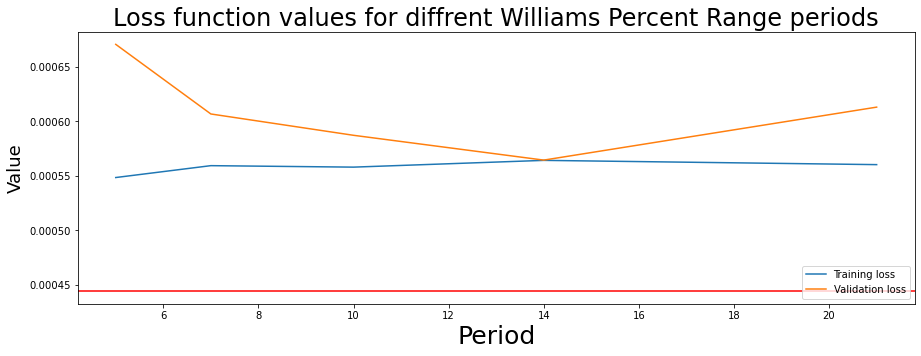

In [54]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent Williams Percent Range periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_WPI['period'], results_WPI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

In [55]:
end = time.time()
print('Time of executing the script: ' + str(round((end - start)/3600, 2)) + 'h')

Time of executing the script: 1.65h
